# WGCNA

In this notebook, we'll look at WGCNA for the transcriptomic data.

In [14]:
from os import listdir
import pandas as pd
import numpy as np
import PyWGCNA

## Formatting data for WGCNA analysis
PyWGCNA requires a specific set of input files, as specified [here](https://github.com/mortazavilab/PyWGCNA/blob/main/tutorials/Data_format.md). We need three main components:

* Gene expression -- a TPM matrix with sample ID's on the index and gene ID's as the columns
* Gene metadata -- index is gene ID's, columns are gene_name and gene_type
* Sample metadata -- index is sample ID's, and columns are any metadata like time or treatment

### Sample metadata
It's actually easiest for us to start here, because we can get the condition metadata from the filenames of the kallisto quant output.

In [26]:
samples = pd.DataFrame(listdir('../data/kallisto_quant_bs/'), columns=['Sample_id'])
samples['Oxygen'] = samples.Sample_id.str.split('_').str[1].str.split('o').str[0]
samples['Time'] = samples.Sample_id.str.split('_').str[0]
samples = samples.set_index('Sample_id')
samples.head()

,Oxygen,Time
Sample_id,,
7h_21o2_c,21,7h
1h_40o2_b,40,1h
1h_40o2_d,40,1h
7h_2o2_b,2,7h
7h_2o2_a,2,7h


### Gene expression
The kalliso quant output `abundance.tsv` files contain TPM for each sample. We will need to use the gene ID conversion from transcript ID that was provided with the transcriptome we used.

In [3]:
tx2gene = pd.read_csv('../data/AtRTD3_gene_transcript.csv').set_index('TXNAME').to_dict()['GENEID']

In [4]:
samps_path = '../data/kallisto_quant_bs'
all_tpms = {}
for samp in listdir(samps_path):
    abundances = pd.read_csv(f'{samps_path}/{samp}/abundance.tsv', sep='\t')[['target_id', 'tpm']].set_index('target_id').to_dict()['tpm']
    abundances = {tx2gene[k]: v for k, v in abundances.items()}
    all_tpms[samp] = abundances

In [5]:
gene_expression = pd.DataFrame(all_tpms.values(), index=all_tpms.keys())
gene_expression.head()

,AT1G01010,AT1G01020,AT1G03987,AT1G01030,AT1G01040,AT1G01040-AT1G01046,AT1G03993,AT1G01046,AT1G01050,AT1G01050-AT1G01060,...,ATMG09960,ATMG01360,ATMG09980,ATMG01370,ATMG01380,ATMG01390,G38195,ATMG01400,G38197,ATMG01410
7h_21o2_c,0.182558,0.158479,0.492933,0.0,0.000000,0.553941,0.0,0.0,8.983160,0.0,...,20.20590,142.1100,101.0290,231.865,0.00000,14.4865,0.0,0.707446,0.0,1.011100
1h_40o2_b,0.227715,0.000000,0.000000,0.0,0.110530,0.749654,0.0,0.0,0.000007,0.0,...,2.74014,95.8054,13.7007,154.794,0.00000,10.2263,0.0,1.477460,0.0,0.519274
1h_40o2_d,0.212986,0.000000,0.275318,0.0,0.000000,0.636911,0.0,0.0,0.000138,0.0,...,23.44290,113.2170,46.8858,177.930,1.99090,14.2088,0.0,2.235180,0.0,0.370263
7h_2o2_b,0.314642,0.000000,0.000000,0.0,0.000000,0.868337,0.0,0.0,4.559260,0.0,...,12.05880,124.4360,44.2155,215.003,0.00000,12.2470,0.0,2.998390,0.0,1.827920
7h_2o2_a,0.000000,0.000000,0.614352,0.0,0.096682,0.828390,0.0,0.0,0.269334,0.0,...,0.00000,121.7710,48.4659,241.978,1.37847,11.9192,0.0,2.094950,0.0,1.430370


### Gene metadata
We'll get this information from the TAIR file that we downloaded for converting TAIR ID's to gene names, as well as the 

In [6]:
aliases = pd.read_csv('../data/gene_aliases_20241231.txt', sep='\t', header=0, encoding='Windows-1252')
aliases.head()

,locus_name,symbol,full_name
0,18S RRNA,18S RRNA,NaN
1,25S RRNA,25S RRNA,NaN
2,5.8S RRNA,5.8S RRNA,NaN
3,AAN,AAN,ANOTHER ANDANTE
4,AAR1,AAR1,ALLYL ALCOHOL RESISTANT 1


In [7]:
functional_descript = pd.read_csv('../data/Araport11_functional_descriptions_20241231.txt', sep='\t', encoding='Windows-1252')
functional_descript['name_gene'] = functional_descript['name'].str.split('.').str[0] # Get rid of the .1 from all AT gene model names, pretty sure this is fine to do
functional_descript.head()

,name,gene_model_type,short_description,Curator_summary,Computational_description,name_gene
0,AAN,unknown,NaN,Putative QTL located at the top of chromosome ...,NaN,AAN
1,ACL1,unknown,NaN,Mutants are defective in leaf and inflorescenc...,NaN,ACL1
2,ACL2,unknown,NaN,Loss of function mutants have reduced internod...,NaN,ACL2
3,ACL3,unknown,NaN,Loss of function mutants have reduced internod...,NaN,ACL3
4,ADD1,unknown,NaN,Temperature-sensitive gene required for normal...,NaN,ADD1


In [41]:
gene_metadata = pd.merge(aliases, functional_descript, left_on='locus_name', right_on='name_gene', how='outer')
gene_metadata = gene_metadata[gene_metadata['locus_name'].isin(gene_expression.columns)][['locus_name', 'symbol', 'gene_model_type']]
gene_metadata.head()

,locus_name,symbol,gene_model_type
141,AT1G01010,ANAC001,protein_coding
142,AT1G01010,NAC001,protein_coding
143,AT1G01010,NTL10,protein_coding
144,AT1G01020,ARV1,protein_coding
145,AT1G01020,ARV1,protein_coding


There are two more modifications we have to make to the metadata frame: first, we need to make sure there is only one row per TAIR locus name, and then add back the chimeric and novel genes from the transcriptome we used that aren't represented in Araport11. We'll keep the first row for each locus name for the sake of simplicity.

In [42]:
gene_metadata = gene_metadata.drop_duplicates(subset='locus_name').reset_index(drop=True)

In [43]:
len(gene_metadata), len(gene_expression.columns)

(16020, 40932)

There seems to be a huge discrepancy between the genes in the expression dataframe and the metadata, and I would be shocked if the updated transcriptome had really identified 34k novel transcripts. Let's see what's missing:

In [44]:
missing = list(set(gene_expression.columns) - set(gene_metadata.locus_name))
missing[:10]

['AT4G38932',
 'AT3G08935',
 'AT3G08525',
 'AT3G19200',
 'AT1G20875',
 'AT4G10830',
 'AT1G04097',
 'G8813',
 'AT2G41231',
 'AT5G07295']

By and large, it looks like the missing ID's are just normal locus ID's. Why are the dataframes from TAIR so incomplete? Do they jsut exclude any genes that don't have specific names or characterizations? For now, we'll assume that's the case and add them with NaN in the metadata:

In [45]:
to_add = pd.DataFrame({'locus_name': missing, 'symbol': [np.nan]*len(missing), 'gene_model_type': [np.nan]*len(missing)})
to_add.head()

,locus_name,symbol,gene_model_type
0,AT4G38932,NaN,NaN
1,AT3G08935,NaN,NaN
2,AT3G08525,NaN,NaN
3,AT3G19200,NaN,NaN
4,AT1G20875,NaN,NaN


In [46]:
gene_metadata = pd.concat([gene_metadata, to_add])
gene_metadata = gene_metadata.rename(columns=
                                     {'locus_name': 'gene_id',
                                     'symbol': 'gene_name',
                                     'gene_model_type': 'gene_type'})

In [48]:
gene_metadata = gene_metadata.set_index('gene_id')
gene_metadata.head()

,gene_name,gene_type
gene_id,,
AT1G01010,ANAC001,protein_coding
AT1G01020,ARV1,protein_coding
AT1G01030,NGA3,protein_coding
AT1G01040,ASU1,protein_coding
AT1G01046,MIR838A,miRNA_primary_transcript


Now we need to make sure the `gene_metadata` index is in the same order as the `gene_expression` columns:

In [51]:
gene_metadata = gene_metadata.reindex(gene_expression.columns)

### PyWGCNA data object creation
Now that we have the three basic input matrices, we need to put them in the correct types of object.

In [58]:
wgcna = PyWGCNA.wgcna.WGCNA(
    species='arabidopsis thaliana',
    geneExp=gene_expression,
    geneInfo=gene_metadata,
    sampleInfo=samples
)

## WGCNA analysis
Now that we have our input object, we can perform the analysis!

Pre-processing...
	Detecting genes and samples with too many missing values...
	Done pre-processing..



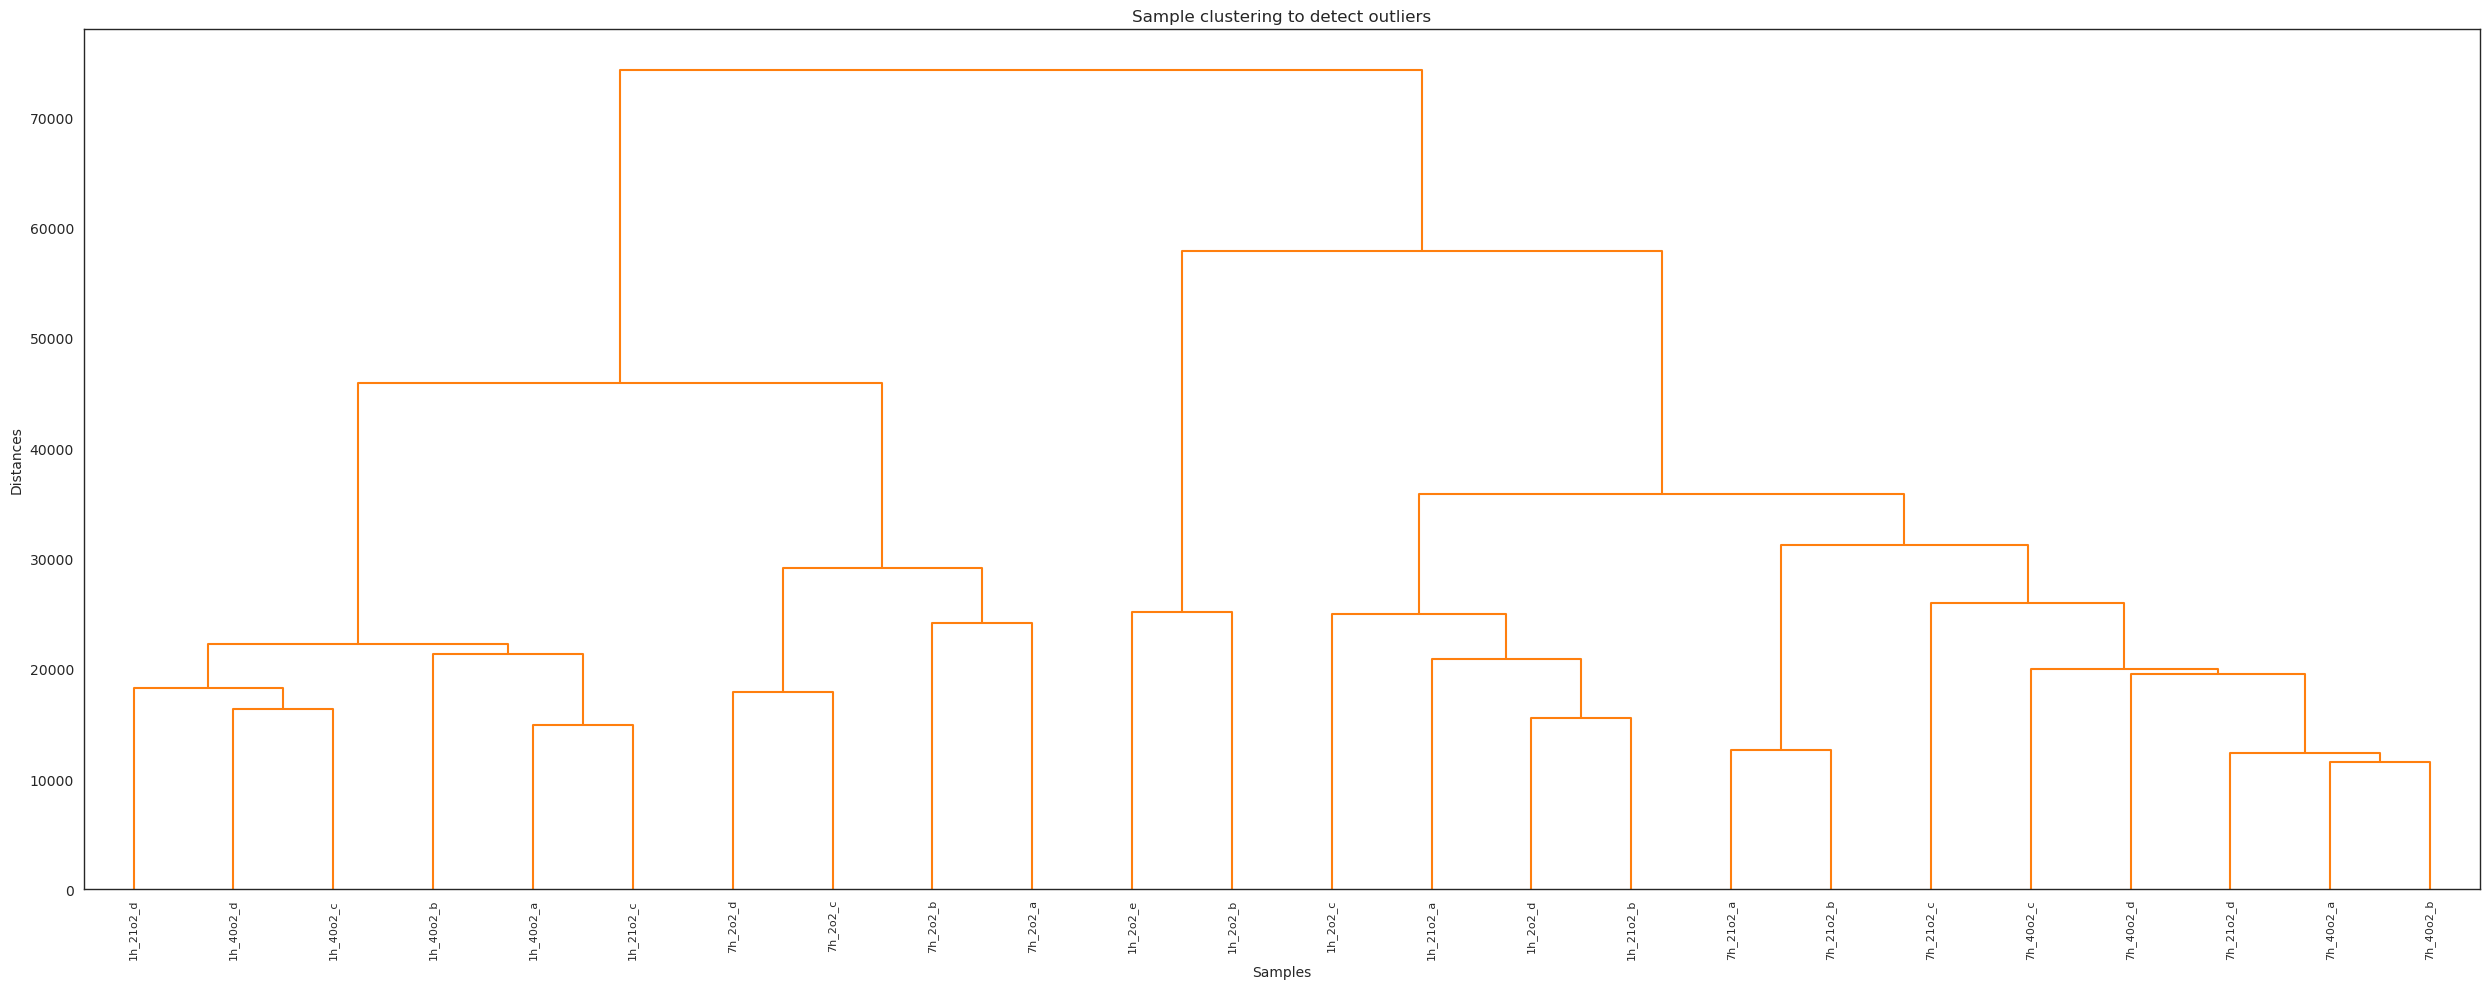

In [59]:
wgcna.preprocess()

Run WGCNA...
pickSoftThreshold: calculating connectivity for given powers...
will use block size  4251
    Power  SFT.R.sq     slope truncated R.sq     mean(k)    median(k)  \
0       1  0.036791 -0.409083       0.934322  1216.89282  1161.714848   
1       2  0.673298  -1.57819        0.95505  458.151105   414.704562   
2       3  0.822533 -1.719486       0.975689  217.957442   186.192428   
3       4  0.865432 -1.816352       0.976375  120.314643    94.301365   
4       5  0.877934 -1.854665       0.973817   73.732922    51.848276   
5       6  0.850847 -1.900711       0.955133   48.845084    31.077477   
6       7  0.843346 -1.901751         0.9526   34.369565     19.35918   
7       8  0.850895 -1.843601       0.967842   25.375149    12.557099   
8       9  0.839734 -1.817138       0.964086   19.483344     8.410313   
9      10  0.810141  -1.79069       0.938077   15.453862     5.755966   
10     11  0.797815 -1.717326       0.909969   12.597565     3.994318   
11     13  0.896328 -

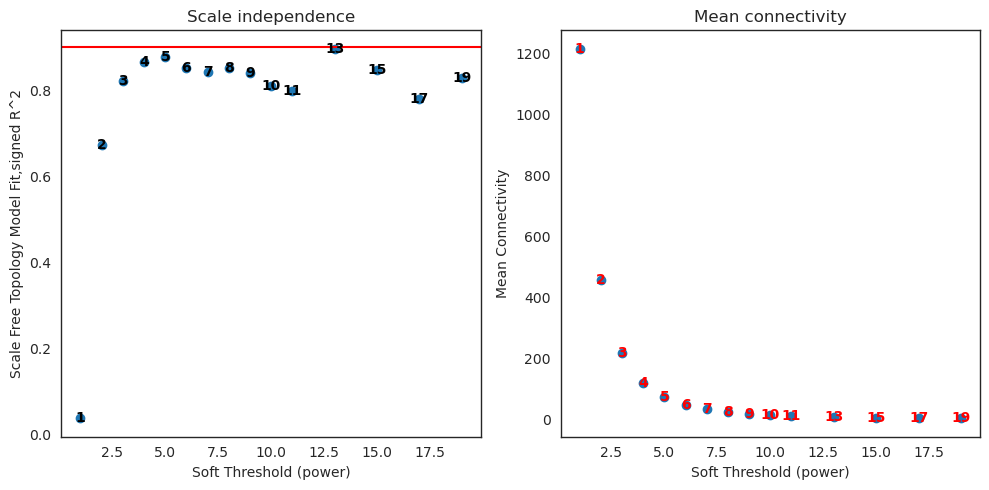

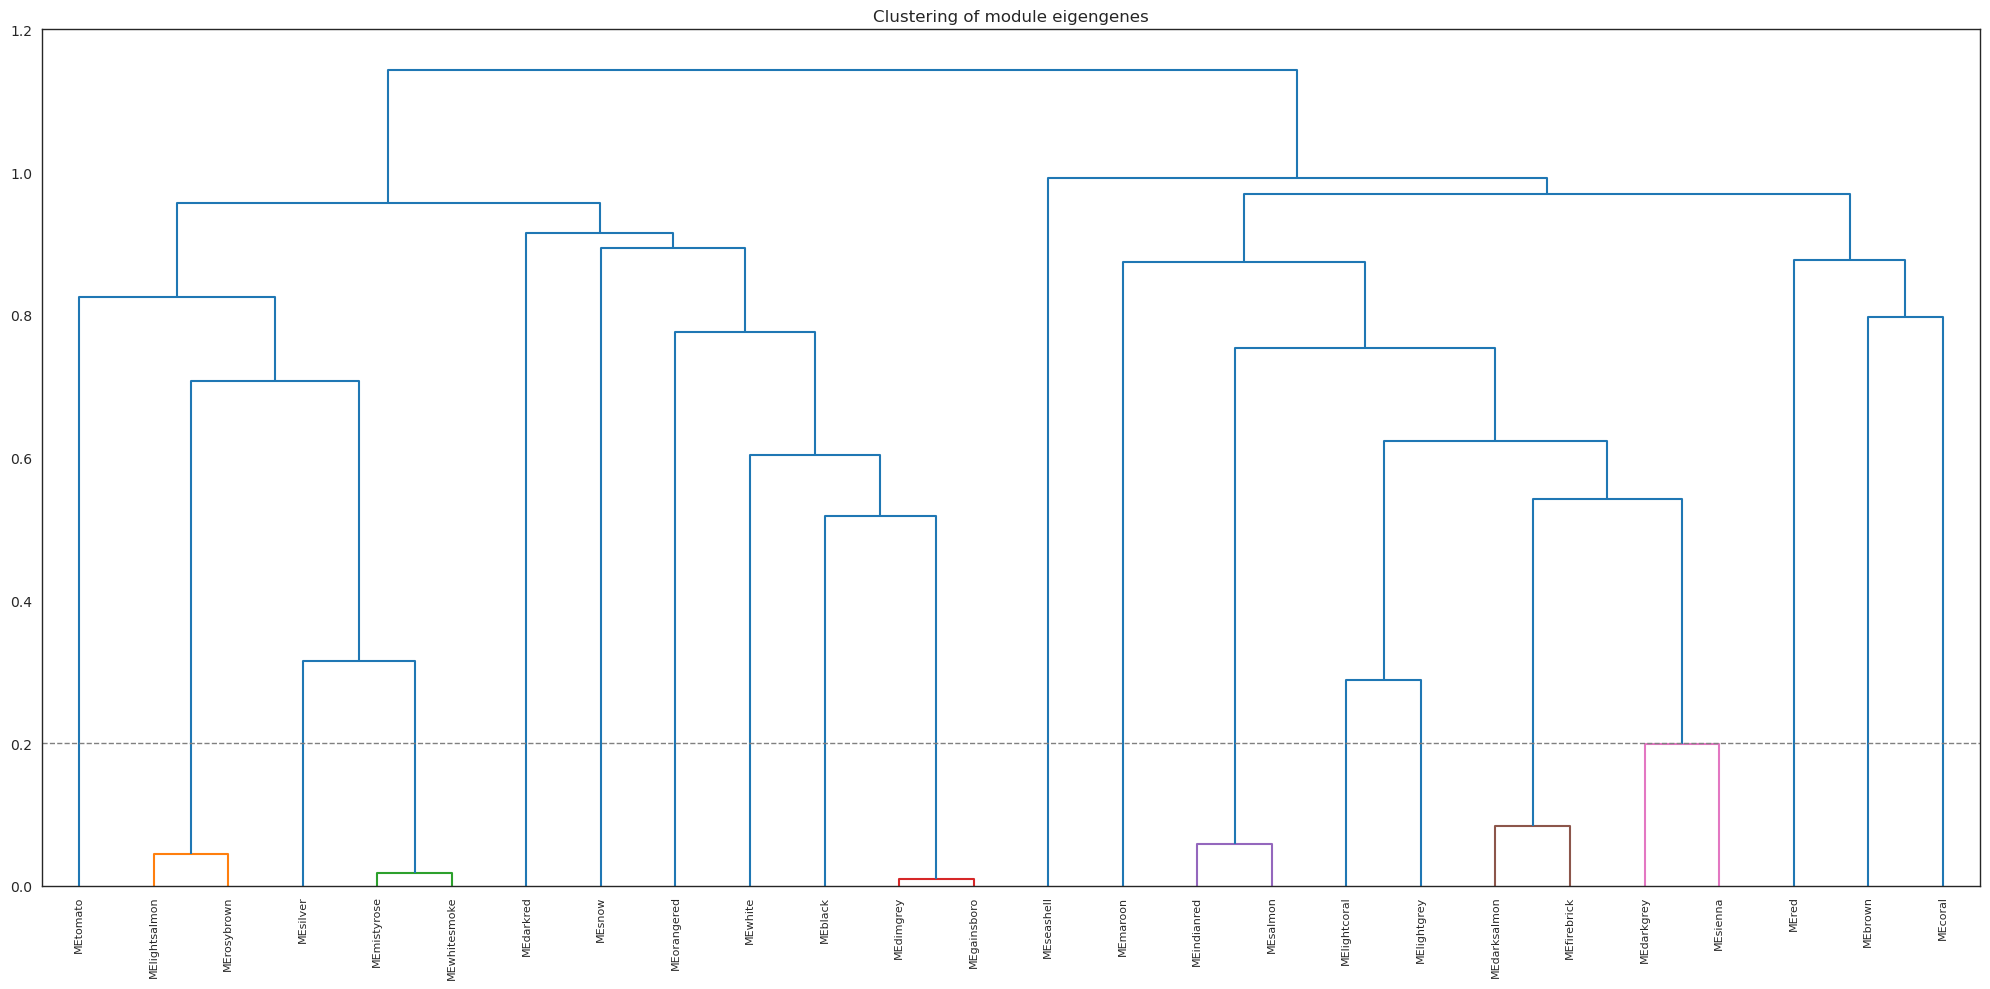

In [61]:
wgcna.findModules()

Unfortunately our network is definitely not scale-free; however, recent work has shown that almost no biological networks are actually scale-free even if they're well fit by a scale-free topology model, which means the scale-free assumption is bascially always violated for this analysis, even with more well-behaved data. Therefore, we are going to carry on with the analysis and see what we get.

Before we do any further analysis, we have to assign colors for the treatments and times:

In [64]:
wgcna.setMetadataColor('Time', {'1h': 'green',
                                '7h': 'yellow'})
wgcna.setMetadataColor('Oxygen', {2: 'darkviolet',
                                21: 'deeppink',
                                40: 'plum'})

Analysing WGCNA...
Calculating module trait relationship ...
	Done..

Adding (signed) eigengene-based connectivity (module membership) ...
	Done..



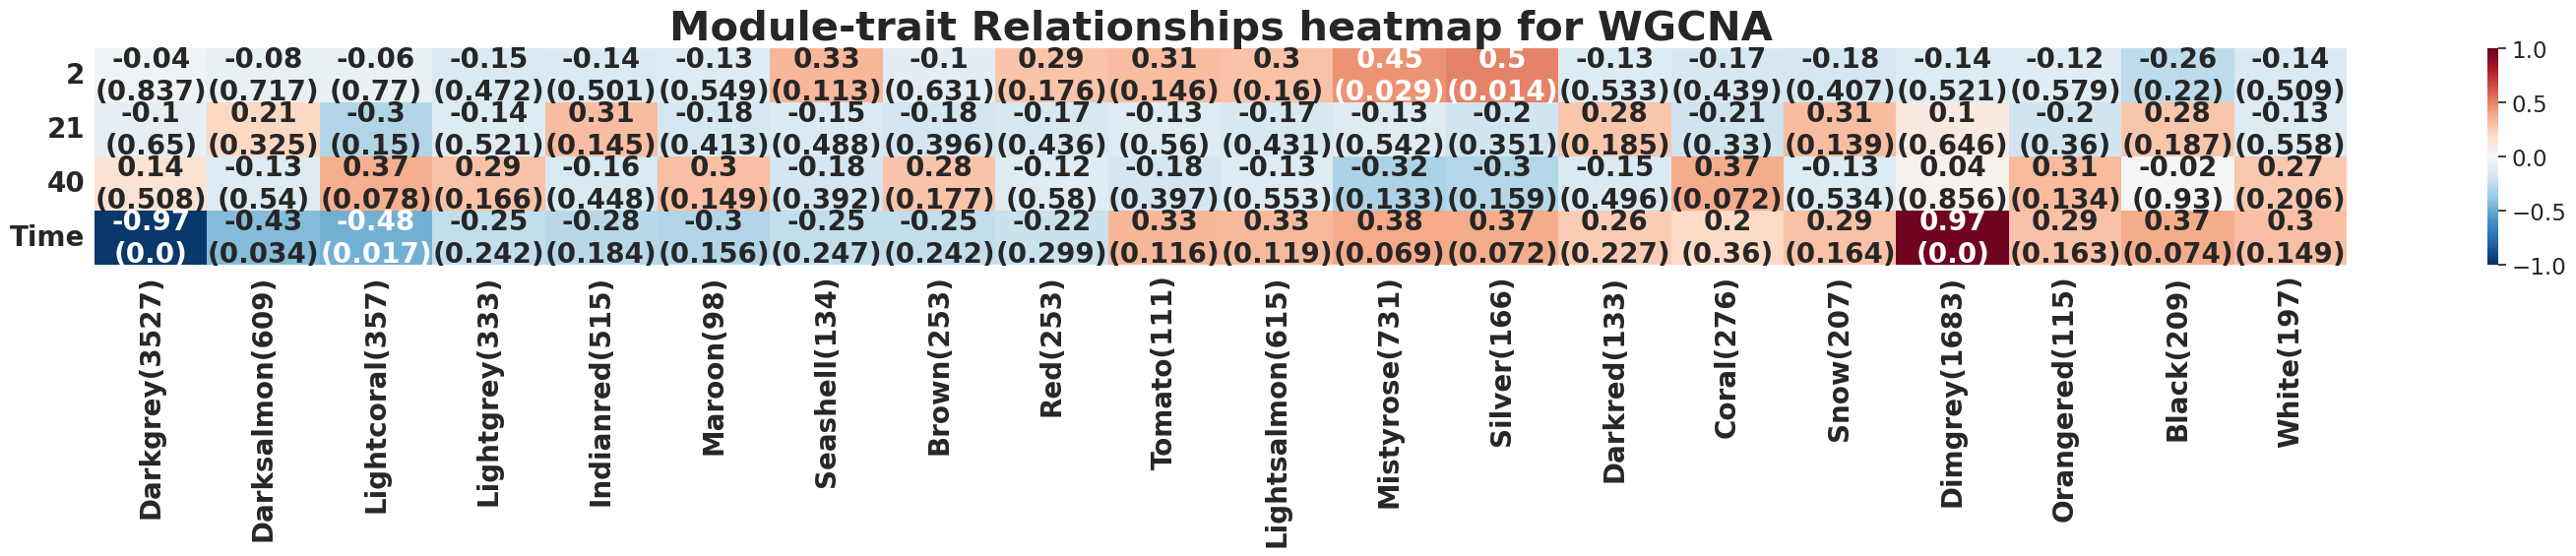

In [66]:
wgcna.analyseWGCNA()

Something I'm interested in looking at is the expression patterns of the module eigengenes:

In [65]:
eigengenes = wgcna.moduleEigengenes()

TypeError: WGCNA.moduleEigengenes() missing 2 required positional arguments: 'expr' and 'colors'

In [62]:
wgcna.plotModuleEigenGene()

TypeError: WGCNA.plotModuleEigenGene() missing 2 required positional arguments: 'moduleName' and 'metadata'